# Starbucks Capstone Challenge


### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
transcript.shape, profile.shape, portfolio.shape

((306534, 4), (17000, 5), (10, 6))

In [8]:
# We can observe from the portfolio dataset that there are 10 different offers that have been available to the customers.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
# Lets clean the data in the portfolio dataset:
def clean_portfolio(portfolio):
    """
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    """
    cleaned_portfolio=portfolio.copy()
    # We have that in days so converting it into no of hours
    cleaned_portfolio['duration']= cleaned_portfolio['duration']*24
    # Checking whether the offer belongs to which meduim:
    cleaned_portfolio['web']=cleaned_portfolio['channels'].apply(lambda x:1 if 'web' in x else 0)
    cleaned_portfolio['email']=cleaned_portfolio['channels'].apply(lambda x:1 if 'email' in x else 0)
    cleaned_portfolio['mobile']=cleaned_portfolio['channels'].apply(lambda x:1 if 'mobile' in x else 0)
    cleaned_portfolio['social']=cleaned_portfolio['channels'].apply(lambda x:1 if 'social' in x else 0)
    # Let's apply one hot encoding for the offer type:
    offer_type=pd.get_dummies(cleaned_portfolio['offer_type'])
    # Then let's drop the columns that we applied one hot encoding:
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    # Combining the above dataframes:
    cleaned_portfolio= pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    return cleaned_portfolio

In [10]:
cleaned_portfolio = clean_portfolio(portfolio)

In [11]:
cleaned_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# Now lets clean the profile dataset as well:
def clean_profile(profile):
    '''
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    '''
    # age: We can see that we have missing values for age 118:
    profile['age']=profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # Dropping all the missing value data:
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    return profile

In [14]:
cleaned_profile=clean_profile(profile)

In [15]:
cleaned_profile.head()

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1314
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1381
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1029
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1105
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1195


In [16]:
cleaned_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1460.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,938.000000
25%,42.000000,2.016052e+07,49000.000000,1146.000000
50%,55.000000,2.017080e+07,64000.000000,1296.000000
75%,66.000000,2.017123e+07,80000.000000,1735.000000
max,101.000000,2.018073e+07,120000.000000,2761.000000


In [17]:
def display_customer_profile_details():
    '''Display customer profile with histograms'''
    # Histogram of Customer Age:
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age:')
    user_age.set_xlabel("Customer Age")
    # Histogram of the days being member:
    plt.figure()
    memberdays = cleaned_profile['memberdays'].plot(kind='hist',bins=50, title='How long did the users become our members:')
    memberdays.set_xlabel("Days")
    # Histogram of User Income:
    plt.figure()
    user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income:')
    user_income.set_xlabel("Income")

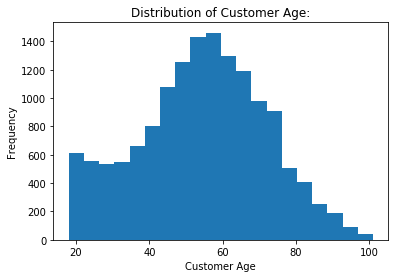

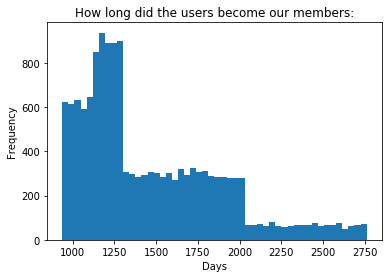

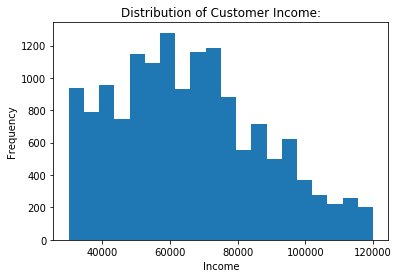

In [18]:
display_customer_profile_details()

In [19]:
# Let's explore transcript:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [21]:
transcript.shape

(306534, 4)

In [22]:
# To explore any one person in the transcripts:
transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [23]:
def clean_transcript(transcript):
    '''
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed):
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    # extract the offer id from value column:
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [24]:
offer = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [25]:
offer.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [26]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [27]:
# This is to understand how many times the offer was sent
offer[offer['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [28]:
offer[offer['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4


In [29]:
offer.shape

(167581, 5)

In [30]:
offer.columns

Index(['event', 'person', 'time', 'value', 'offer_id'], dtype='object')

In [33]:
user_item_mat.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
user_item_mat = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
# An example user_item_matrix

In [34]:
list(portfolio[portfolio['offer_type']=='informational']['id'])

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [35]:
user_item_mat.drop(list(portfolio[portfolio['offer_type']=='informational']['id']),axis=1,inplace=True)

In [36]:
user_item_mat.shape[0]

16994

In [37]:
def create_user_item_matrix1(offer, filename):    
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [ ]:
# Don't run this every time as we have saved the matrix into a pickle file:
full_df= create_user_item_matrix(offer,'user_item_matrix2.p')

In [38]:
# We can just read in the pickle files of the user_item matrices than computing each and every time.
full_df = pd.read_pickle('user_item_matrix2.p')

In [39]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [40]:
# Now let's divide the main dataframe into training and testing dataframes:
train_size= int(offer.shape[0]*0.7) # 70% FOR THE TRAINING SET
test_size= int(offer.shape[0]-train_size) # THE OTHER REMAINING 30% FOR THE TEST SET
train_size, test_size

(117306, 50275)

In [41]:
train_offer= offer[:train_size]
test_offer= offer[train_size:]

In [42]:
test_offer.shape

(50275, 5)

In [43]:
train_offer.shape

(117306, 5)

In [44]:
print("continue")

continue


In [45]:
train_dataframe= create_user_item_matrix1(train_offer,'train_df2.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [45]:
train_df = pd.read_pickle('train_df2.p')

In [47]:
test_dataframe = create_user_item_matrix(test_offer, 'test_df2.p')

Computing :  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished 5.884429798752501%
Finished 11.768859597505003%
Finished 17.653289396257502%
Finished 23.537719195010006%
Finished 29.422148993762505%
Finished 35.306578792515005%
Finished 41.19100859126751%
Finished 47.07543839002001%
Finished 52.95986818877251%
Finished 58.84429798752501%
Finished 64.7287277862775%
Finished 70.61315758503001%
Finished 76.4975873837825%
Finished 82.38201718253502%
Finished 88.26644698128752%
Computing :  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished 5.884429798752501%
Finished 11.768859597505003%
Finished 17.653289396257502%
Finished 23.537719195010006%
Finished 29.422148993762505%
Finished 35.306578792515005%
Finished 41.19100859126751%
Finished 47.07543839002001%
Finished 52.95986818877251%
Finished 58.84429798752501%
Finished 64.7287277862775%
Finished 70.61315758503001%
Finished 76.4975873837825%
Finished 82.38201718253502%
Finished 88.26644698128752%
Computing :  2906b810c7d4411798c6938adc9daaa5
Finished 5.88442

In [46]:
test_df = pd.read_pickle('test_df2.p')

In [47]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [95]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [49]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [96]:
train_df.shape,test_df.shape

((16955, 8), (15828, 8))

In [51]:
full_df.shape

(16994, 8)

In [59]:
def FunkSVD(complete_mat, latent_features=10,learning_rate=0.001,iters=100):
    """
    This function performs matrix factorizations to understand the user-offer reactions:
    
    INPUT:
    complete_mat- Matrix of user_item intercations without nans and columns are offers and rows are users.
    latent_features- the total number of latent features that we will be using.
    learning_rate- the learning rate to ensure the direction of flow
    iters- The total number of iterations that you want to compute on
    
    OUTPUT:
    user_mat- matrix with users(rows) and latent_features(columns)
    offer_mat- metrix with latent features(rows) and the offers(columns)
    """
    n_users= complete_mat.shape[0]
    n_offers= complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        # update our sse in each and every iteration
        old_sse = sse_accum
        sse_accum = 0
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 

In [60]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.313349
2 		 0.267338
3 		 0.266976
4 		 0.266610
5 		 0.266240
6 		 0.265866
7 		 0.265486
8 		 0.265101
9 		 0.264710
10 		 0.264314
11 		 0.263910
12 		 0.263499
13 		 0.263081
14 		 0.262654
15 		 0.262219
16 		 0.261774
17 		 0.261320
18 		 0.260854
19 		 0.260377
20 		 0.259888
21 		 0.259385
22 		 0.258868
23 		 0.258336
24 		 0.257788
25 		 0.257223
26 		 0.256638
27 		 0.256035
28 		 0.255409
29 		 0.254762
30 		 0.254090
31 		 0.253392
32 		 0.252667
33 		 0.251913
34 		 0.251128
35 		 0.250310
36 		 0.249456
37 		 0.248566
38 		 0.247636
39 		 0.246664
40 		 0.245648
41 		 0.244586
42 		 0.243474
43 		 0.242310
44 		 0.241093
45 		 0.239818
46 		 0.238484
47 		 0.237087
48 		 0.235625
49 		 0.234095
50 		 0.232496
51 		 0.230824
52 		 0.229077
53 		 0.227253
54 		 0.225350
55 		 0.223366
56 		 0.221301
57 		 0.219152
58 		 0.216920
59 		 0.214603
60 		 0.212202
61 		 0.209717
62 		 0.207150
63 		 0.204500
64 		 0

In [61]:
#Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.294476
2 		 0.267178
3 		 0.266704
4 		 0.266226
5 		 0.265746
6 		 0.265262
7 		 0.264775
8 		 0.264284
9 		 0.263789
10 		 0.263289
11 		 0.262786
12 		 0.262277
13 		 0.261762
14 		 0.261243
15 		 0.260716
16 		 0.260184
17 		 0.259644
18 		 0.259097
19 		 0.258541
20 		 0.257977
21 		 0.257403
22 		 0.256819
23 		 0.256224
24 		 0.255618
25 		 0.254999
26 		 0.254367
27 		 0.253720
28 		 0.253059
29 		 0.252381
30 		 0.251686
31 		 0.250972
32 		 0.250239
33 		 0.249484
34 		 0.248707
35 		 0.247906
36 		 0.247080
37 		 0.246228
38 		 0.245346
39 		 0.244435
40 		 0.243491
41 		 0.242514
42 		 0.241502
43 		 0.240452
44 		 0.239363
45 		 0.238232
46 		 0.237059
47 		 0.235840
48 		 0.234574
49 		 0.233259
50 		 0.231893
51 		 0.230474
52 		 0.229001
53 		 0.227471
54 		 0.225883
55 		 0.224235
56 		 0.222527
57 		 0.220757
58 		 0.218924
59 		 0.217027
60 		 0.215066
61 		 0.213040
62 		 0.210950
63 		 0.208796
64 		 0

In [62]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.278230
2 		 0.268715
3 		 0.267885
4 		 0.267049
5 		 0.266211
6 		 0.265373
7 		 0.264535
8 		 0.263696
9 		 0.262857
10 		 0.262017
11 		 0.261177
12 		 0.260336
13 		 0.259494
14 		 0.258653
15 		 0.257810
16 		 0.256967
17 		 0.256124
18 		 0.255279
19 		 0.254434
20 		 0.253589
21 		 0.252742
22 		 0.251894
23 		 0.251046
24 		 0.250197
25 		 0.249346
26 		 0.248494
27 		 0.247641
28 		 0.246786
29 		 0.245930
30 		 0.245072
31 		 0.244212
32 		 0.243351
33 		 0.242487
34 		 0.241621
35 		 0.240752
36 		 0.239881
37 		 0.239006
38 		 0.238129
39 		 0.237248
40 		 0.236364
41 		 0.235476
42 		 0.234583
43 		 0.233687
44 		 0.232785
45 		 0.231879
46 		 0.230967
47 		 0.230050
48 		 0.229127
49 		 0.228197
50 		 0.227261
51 		 0.226317
52 		 0.225366
53 		 0.224407
54 		 0.223440
55 		 0.222463
56 		 0.221478
57 		 0.220483
58 		 0.219477
59 		 0.218461
60 		 0.217433
61 		 0.216394
62 		 0.215342
63 		 0.214278
64 		 0

In [63]:
user_ids=np.array(train_df.index)

In [64]:
user_ids

array(['0009655768c64bdeb2e877511632db8f',
       '00116118485d4dfda04fdbaba9a87b5c',
       '0011e0d4e6b944f998e987f904e8c1e5', ...,
       'fff8957ea8b240a6b5e634b6ee8eafcf',
       'fffad4f4828548d1b5583907f2e9906b',
       'ffff82501cea40309d5fdd7edcca4a07'], dtype=object)

In [65]:
# Playing with np.where to grab the row index and the col index:
user_row = np.where(user_ids == '0011e0d4e6b944f998e987f904e8c1e5')[0][0]

In [66]:
user_row

2

In [67]:
offer_ids=np.array(train_df.columns)

In [68]:
offer_ids

array(['0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4'], dtype=object)

In [69]:
def predict_reaction(user_matrix,offer_matrix,user_id,offer_id):
    """
    INPUT:
    user_matrix- user and latent features matrix
    offer_matrix- latent features and offers matrix
    user_id- the user_id
    offer_id- the offer_id

    OUTPUT:
    pred- We will return the prediction offer for the user-offer interaction
    """
    # We can use a try-catch block for our user_offer if it doesnt exist it will move to the except block
    try:
        user_ids=np.array(train_df.index)
        offer_ids=np.array(train_df.columns)
        user_row=np.where(user_ids==user_id)[0][0]
        offer_col=np.where(offer_ids==offer_id)[0][0]
        pred= np.dot(user_matrix[user_row,:],offer_matrix[:,offer_col])
        return pred
    except:
        return None

In [70]:
# Just to check everything is working fine :)
predict_reaction(user_mat,offer_mat,'00116118485d4dfda04fdbaba9a87b5c','2298d6c36e964ae4a3e7e9706d1fb8c2')

-0.7232348922893439

In [75]:
def validation1(test_df, user_mat, offer_mat):
    """
    Input:
    test_df- we will consider the test data set
    user_mat- user_matrix which is obtained from the funksvd
    offer_mat- offer_matrix which is obtained from the funksvd
    
    Output: 
    sse_accum- Squared errors for our prediction
    """
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [90]:
# Validation for the default 10 latent features on test data set of user_item_matrix:
validation1(test_df, user_mat, offer_mat)

0.336228599544


In [91]:
# Validation for the default 10 latent features on test data set of user_item_matrix:
validation1(test_df, user_mat_10, offer_mat_10)

0.321192036947


In [92]:
# Validation for the 5 latent features on test data set of user_item_matrix:
validation1(test_df, user_mat_5, offer_mat_5)

0.297652987778


In [77]:
def best_sale_offer_for_new_user(user_item_matrix):
    """
    INPUT: 
    user_item_matrix: we give our user-item matrix as our input
    
    OUTPUT:
    We will return the best offers based on the sales and we convey it using the bar graphs.
    
    """
    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [78]:
def recommend_offer(user_id, user_mat, offer_mat):
    """
    INPUT: 
    user_id- user_id from the user_item matrix or a completely new user: 
    user_mat- the user_mat from FunkSVD
    offer_mat- the offer_mat from FunkSVD
    
    OUTPUT:
    We will return the best offers based on the sales and we convey it using the bar graphs if he is a new user.
    
    """
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer_for_new_user(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [79]:
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.74
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.64
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  1.18
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.93
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.91
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.6
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.08
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.02


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


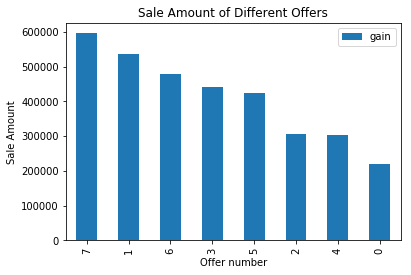

In [80]:
recommend_offer('new_user', user_mat, offer_mat)
# We get the recommendation as he is a new user:

In [81]:
def gender_offer(full_df):
    '''
    INPUT:
    full_df- 
    
    OUTPUT:
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

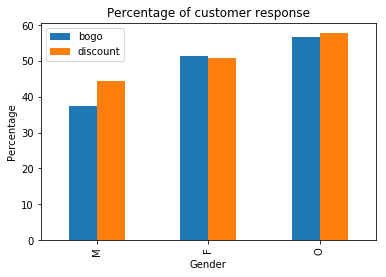

In [82]:
gender_offer(full_df)
# WE CAN OBSERVE THAT THE CUSTOMER RESPONSE IS GOOD FOR DISCOUNTS IN OTHERS AND MALE GENDERS BUT FEMALES RESPOND MORE TO BOGO THAN A DISCOUNT OFFER:

In [83]:
cleaned_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [93]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")


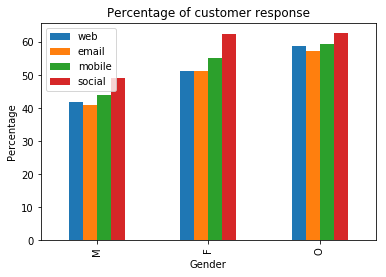

In [94]:
gender_offer_channel(full_df)
# We can observe that the customer response is good via social media ads than web, email and mobile: